# Libraries

In [1]:
from __future__ import division, print_function
from importlib import import_module

import os
import sys
import numpy as np
from numpy import linalg
from numpy.polynomial.polynomial import polyval
import scipy.io as sio
import matplotlib.pyplot as plt
import math
from math import pi

# Import tqdm (progress bar)
try:
    library = import_module('tqdm')
except:
    print(sys.exc_info())
else:
    globals()['tqdm'] = library

from lib import *

from IPython.display import clear_output
%matplotlib inline

# Directories

In [2]:
# Data files
name_folder = 'export'
name_export = 'eigen_heatmap'

name_import = 'eigen_heatmap'

# Directory
dir_main = os.getcwd()
dir_folder = os.path.join(dir_main, 'data', name_folder)
dir_export = os.path.join(dir_folder, name_export)
dir_import = os.path.join(dir_folder, name_import)

# Set-up

In [3]:
# Model parameters
N = 30
w0 = 1.0
g = 1.5
a = 1.0
T = 0.05
gain = 30

# Fixed-point values (obtain b from asy_script)
b = np.array([ 1.00397807,  0.32372869, -0.70999044,  2.50302449, -3.53600262,
         1.84001616])
phi_fun = lambda X: polyval(X, b)

par = {'N': N,
       'g': g,
       'T': T,
       'omega0': w0,
       'a': a,
       'gain': gain
       }

fun = lambda u: w0 + g*a*funlib.R_sum(u, N**2, N, par, phi_fun) - u

Omega = rootlib.find_root(fun, w0, w0-g, w0+g, steps=20)
phi = phi_fun(np.arange(N)/N)

# tauE, Delta
Delta = (phi[:, None] - phi).T

tau0 = 2*T*np.random.random(size=(N,N))
zeros = np.zeros((N,N))
tauE = np.maximum(tau0 + gain*Delta, zeros)

# Eigenvalues

In [4]:
det_z = lambda z: linalg.slogdet(eigenlib.M(z, g, gain, Omega, tauE, Delta))

# Heatmap array
u_min, u_max, N_u = -50, 50, 30
v_min, v_max, N_v = -50, 50, 30

# Bounds
L_z, U_z = -1000, 1000

# Obtain mesh of region
u_part = np.linspace(u_min, u_max, N_u)
v_part = np.linspace(v_min, v_max, N_v)
v_mesh, u_mesh = np.meshgrid(v_part, u_part)

# Compute every value of |f|
det_mesh = np.zeros((N_u, N_v))

# Progress bar
try:
    total = N_u*N_v
    pbar = tqdm.tqdm(total=total-1)
    up_num = 1            
except:
    print('tqmb package missing! No progress bar defined.')
    is_bar = False
else:
    is_bar = True
    
for k in range(N_u):
    for l in range(N_v):
        det_mesh[k,l] = det_z(u_mesh[k,l] + v_mesh[k,l]*1j)[1]
        
        # Update progress bar (pbar):
        if is_bar:
            pbar.update(up_num)
        

# Bound mesh
det_mesh = np.maximum(det_mesh, L_z*np.ones(det_mesh.shape))
det_mesh = np.minimum(det_mesh, U_z*np.ones(det_mesh.shape))

100%|████████████████████████████████████████| 899/899 [00:59<00:00, 16.40it/s]

# Export

In [5]:
# Define dictionary
mat_det = {'det_mesh': det_mesh.T,
           'u_mesh': u_mesh.T,
           'v_mesh': v_mesh.T,
           'u': np.array([u_min, u_max, N_u])[:,None],
           'v': np.array([v_min, v_max, N_v])[:,None],
           'bounds': np.array([L_z, U_z])[:,None]
          }

# Export
sio.savemat(dir_export, mat_det)

# Plot heatmap

## Import

In [6]:
mat_im = sio.loadmat(dir_import)

# Define all values
det_mesh = mat_im['det_mesh']
u_mesh = mat_im['u_mesh']
v_mesh = mat_im['v_mesh']
u_min, u_max, N_u = mat_im['u']
v_min, v_max, N_v = mat_im['v']
L_z, U_z = mat_im['bounds']

## Plot

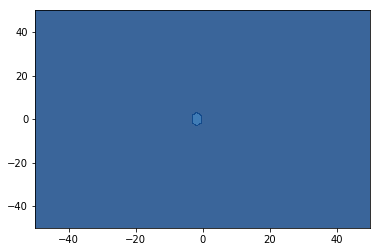

900it [01:10, 16.40it/s]                                                       

In [7]:
fig, ax = plt.subplots(1,1)

ax.set_xlim(u_min, u_max)
ax.set_ylim(v_min, v_max)


alpha = 0.8
levels = np.linspace(L_z, U_z, 10)

ax.contourf(u_mesh, v_mesh, det_mesh, levels, cmap='Blues', alpha=alpha)